In [167]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import statistics
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import gensim
from gensim.models import KeyedVectors
import numpy as np
from collections import Counter
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases
from nltk import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim.downloader as api
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from preprocessing import *

In [168]:
w2v_pretrained = Word2Vec.load("w2vPreTrained")

In [169]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(subset = "verified_reviews", inplace = True)
print(dataset.shape)

(3150, 5)
(3150, 5)
(2998, 5)
(2196, 5)


In [170]:
X = np.array(dataset["verified_reviews"].values).reshape(-1, 1)
y = list(dataset["feedback"].values)

In [171]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state = 0)

X, y = undersampler.fit_resample(X, y)


print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({1: 412, 0: 206})


In [172]:
X_temp = []

for rev in X:
  X_temp.append(rev[0])

In [173]:
new_text, new_sent_tok = tokenize_list_of_text(X_temp, custom_stopwords, False, 2)

total number of types extracted is: 1798


In [174]:
# Elimino token con freq minore di 2
cleaned_reviews = frequency_cleaning(new_sent_tok, 2)

In [175]:
bigrams = Phrases(cleaned_reviews, scoring="npmi", threshold=0.60) #estrae le collocazioni tramite PMI
bigrams[cleaned_reviews][2]

['little', 'feature']

In [176]:
X_train, X_test, Y_train, Y_test = train_test_split(bigrams[cleaned_reviews], y, test_size=0.20, random_state=10)

In [177]:
negative_reviews = []
for rev, label in zip(X_train, Y_train):
    if label == 0:
        negative_reviews.append(rev)
    
generated_reviews = generate_samples(negative_reviews, int(len(negative_reviews)/2), w2v_pretrained)

# run this only one time
X_train.extend(generated_reviews)
Y_train.extend([0 for x in generated_reviews])

['joke']
-
['laugh']
--------------------------
['price', 'product', 'nice', 'quality', 'nice', 'feature', 'definitely', 'reason', 'give', 'think', 'may', 'buyer', 'error', 'first', 'ignore', 'product', 'plug', 'time', 'work', 'really', 'unlike', 'not_a', 'stand', 'device', 'also', 'speaker', 'not_very', 'loud', 'buy', 'bluetooth', 'speaker', 'sure', 'lot', 'figure', 'use', 'kind', 'seem', 'like', 'device', 'plus', 'set', 'awful', 'would', 'definitely', 'money', 'buy', 'one', 'actually']
-
['cost', 'product', 'decent', 'quality', 'decent', 'feature', 'definitely', 'reason', 'present', 'imagine', 'may', 'buyer', 'error', 'start', 'ignore', 'product', 'plug', 'sentence', 'run', 'truly', 'different', 'not_a', 'base', 'device', 'also', 'speaker', 'not_very', 'loudly', 'purchase', 'bluetooth', 'speaker', 'sure', 'plenty', 'figure', 'utilize', 'kind', 'seem', 'wish', 'device', 'plus', 'adjust', 'terrible', 'would', 'definitely', 'money', 'purchase', 'one', 'really']
-------------------------

In [178]:
# Questa parte estrare le parole più rilevanti per ogni categoria, ma non la uso alla fine.
# Lo riprenderò più avanti
# FARE IL K-SQUARED

neg_tokenized = [rev for rev, feedback in zip(X_train, Y_train) if feedback == 0]
pos_tokenized = [rev for rev, feedback in zip(X_train, Y_train) if feedback == 1]
neg_tokenized = [w for rev in neg_tokenized for w in rev]
pos_tokenized = [w for rev in pos_tokenized for w in rev]

import math 

def get_pos_neg_score(pos, neg):

    # MI(word, category) = log2(p(word, category) / (p(word) * p(category)))


    total_tokens = pos + neg
    total_tokens_freq = nltk.FreqDist(total_tokens)
    pos_freq = nltk.FreqDist(pos)
    neg_freq = nltk.FreqDist(neg)
    data_dict = {"pos": {}, "neg": {}}

    for w in pos:
        p_category = pos_freq[w] / total_tokens_freq[w]
        p = pos_freq[w] / len(pos)
        data_dict["pos"][w] = -math.log2(p_category / (p))
    
    for w in neg:
        p_category = neg_freq[w] / total_tokens_freq[w]
        p = neg_freq[w] / len(neg)
        h = -math.log2(p)
        data_dict["neg"][w] = -math.log2(p_category / (p))

    pos_list = list(data_dict["pos"].values())
    neg_list = list(data_dict["neg"].values())
    scaled_pos = [(float(i)-min(pos_list))/(max(pos_list)-min(pos_list)) for i in pos_list]
    scaled_neg = [((float(i)-min(neg_list))/(max(neg_list)-min(neg_list))) - 1 for i in neg_list]

    data_dict["pos"] = {k: v for k, v in zip(data_dict["pos"], scaled_pos)}
    data_dict["neg"] = {k: v for k, v in zip(data_dict["neg"], scaled_neg)}
    
    pos_sorted = {k: v for k, v in sorted(data_dict["pos"].items(), key = lambda item: item[1], reverse=True)}
    neg_sorted = {k: v for k, v in sorted(data_dict["neg"].items(), key = lambda item: item[1], reverse=True)}
    data_dict["pos"] = pos_sorted
    data_dict["neg"] = neg_sorted

    risultato = {}

    for w in total_tokens:
        media = statistics.mean([data_dict["pos"].get(w, 0), data_dict["neg"].get(w, 0)])
        risultato[w] = media

    return {k: v for k, v in sorted(risultato.items(), key = lambda item: item[1], reverse=True)}

data_dict = get_pos_neg_score(pos_tokenized, neg_tokenized)

In [179]:
data_dict

{'device': 0.5,
 'love': 0.4853923490580126,
 'work': 0.4646668593232431,
 'get': 0.4452941270062397,
 'use': 0.4319197270622712,
 'one': 0.41970402692795933,
 'great': 0.4154618209420086,
 'product': 0.40669968648496807,
 'like': 0.404448296117033,
 'would': 0.4021714657715822,
 'good': 0.3726312554458365,
 'buy': 0.3645161718318184,
 'thing': 0.3645161718318184,
 'time': 0.3283301554733585,
 'screen': 0.3146640826075615,
 'speaker': 0.30746698391454674,
 'sound': 0.2961651054900137,
 'music': 0.2841914442336289,
 'well': 0.28003671267564023,
 'also': 0.2757945066896894,
 'day': 0.2670323722326489,
 'show': 0.2670323722326489,
 'want': 0.25787182471126163,
 'set': 0.25787182471126163,
 'purchase': 0.2482748994521366,
 'still': 0.2482748994521366,
 'easy': 0.2482748994521366,
 'try': 0.2482748994521366,
 'need': 0.23819793265173878,
 'best': 0.23198238757612066,
 'still_learn': 0.23198238757612066,
 'new': 0.22759036030010038,
 'home': 0.22759036030010038,
 'kitchen': 0.221367455666363

In [180]:
# tfidf weighting sui token, per ora senza pos. Mi sono reso conto che la pos per averla più accurata la devo fare prima del pre processing.

tfidf = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, min_df = 0)
tfidf_model = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
review = 12
for score, feature in zip(tfidf_model.toarray()[review], tfidf.get_feature_names_out()):
    if score > 0.0:
        print(feature, score)

've 0.26903380239120317
control 0.2348044472798319
every 0.2639510163233244
feature 0.2180774379141343
get 0.15366618732927326
house 0.444692053288926
light 0.23206903284011626
like 0.1622970961853006
offer 0.30599857194229
one 0.3203555771627112
play_music 0.23206903284011626
purchase 0.200723022609278
really 0.20869738395969983
room 0.22946710755575483
think 0.214125342039853
work 0.145708855801675


In [181]:
tfidf.inverse_transform(tfidf_model)[0]

array(['purchase', 'new', 'like', 'look', 'box', 'original',
       'even_though', 'perfectly', 'work', 'far', 'week', 'two',
       'refurbish', 'happy'], dtype='<U15')

In [182]:
print(tfidf_model[0,:].data)
tfidf.inverse_transform(tfidf_model)[0]

[0.20289746 0.21455331 0.16405527 0.22704895 0.28397716 0.2668104
 0.27762788 0.29948513 0.14728732 0.2127258  0.27194825 0.23734809
 0.22944519 0.51561017]


array(['purchase', 'new', 'like', 'look', 'box', 'original',
       'even_though', 'perfectly', 'work', 'far', 'week', 'two',
       'refurbish', 'happy'], dtype='<U15')

In [183]:
w2v_model = Word2Vec(X_train, vector_size=100, window = 10, min_count = 0, sg=1, hs = 1, epochs= 100, seed = 5)

In [184]:
w2v_model.wv.most_similar("love", topn = 10)

[('great', 0.5367417931556702),
 ('get', 0.49619752168655396),
 ('use', 0.4509217441082001),
 ('kitchen', 0.44389069080352783),
 ('cook', 0.43931204080581665),
 ('show', 0.4102255403995514),
 ('fun', 0.39854246377944946),
 ('like', 0.3985327482223511),
 ('recognition', 0.39414140582084656),
 ('trailer', 0.387723833322525)]

In [185]:
w2v_model.wv.most_similar("love", topn = 2000)[-10:]

[('free', -0.07402048259973526),
 ('sluggish', -0.07937180995941162),
 ('place', -0.0795297846198082),
 ('spend', -0.08012556284666061),
 ('mood', -0.08532152324914932),
 ('blue', -0.09613428264856339),
 ('laugh', -0.10050835460424423),
 ('reboot', -0.1030278429389),
 ('unplug', -0.10371576994657516),
 ('also', -0.12003546953201294)]

In [186]:
df = pd.DataFrame(tfidf_model.toarray(), columns = tfidf.get_feature_names_out())
df

,'ll,'re,'ve,ability,able,absolutely,access,account,across,act,...,worry,worth,worthlessness,would,wrong,yard,year,yes,yet,zigbee
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.891296,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
566,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
567,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
568,0.0,0.0,0.0,0.0,0.402613,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [187]:
g_model = []
# google_model = api.load('word2vec-google-news-300', True)
# g_model = KeyedVectors.load_word2vec_format(google_model, binary=True)

In [188]:
def review_vectors(tokens, size = 300, weights = [], pretrained = False):

    """Genera un vettore per ogni recensione: questo vettore
    è calcolato come la media ponderata (t * w: token vettore * peso tfidf) dei vettori dei token nella recensione.
    Il vettore risultante è normalizzato alla fine."""

    vec = np.zeros(size).reshape((1, size))
    count = 0

    import statistics

    # if len(tokens) != len(weights):
    #     print("nope")

    for word, weight in zip(tokens, weights):
        try:
            if pretrained:
                vec += g_model[word]
            else:
                vec += w2v_model.wv[word] * weight
            count +=1
        except KeyError:
            print("non trovo", word)
            continue

    if count!= 0:
        vec = vec / norm(vec)
        
    return vec

In [189]:
# qui viene creato per ogni recensione il vettore

w2v_X_train = np.zeros((len(X_train), w2v_model.vector_size))
for i in range(len(X_train)):
    w2v_X_train[i,:] = review_vectors(tfidf.inverse_transform(tfidf_model[i, :])[0], w2v_model.vector_size, tfidf_model[i,:].data, False)
w2v_df = pd.DataFrame(w2v_X_train)
w2v_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.038640,0.043740,-0.178607,-0.070404,0.024058,-0.107482,-0.029476,-0.027435,0.215017,-0.211310,...,0.069869,0.015778,-0.042668,-0.027075,-0.069162,0.039295,-0.032389,0.081429,0.031238,0.001340
1,-0.171007,0.055541,-0.157827,0.030892,-0.035748,-0.119520,-0.040774,-0.067100,0.281942,-0.130216,...,-0.084407,-0.071736,-0.058041,0.015649,0.004431,-0.003596,-0.015370,0.165745,0.103072,0.060725
2,-0.078980,-0.220992,-0.041228,-0.038287,0.047936,-0.073509,0.077189,-0.140190,0.069180,-0.181917,...,0.035988,-0.136848,-0.074261,0.207372,0.004960,0.124320,-0.087650,0.019599,0.133624,-0.064038
3,-0.010142,0.156915,-0.086216,0.082199,0.018612,0.009475,-0.057002,-0.012727,0.200708,-0.122241,...,0.055784,0.014244,-0.016973,0.130969,0.093853,0.082298,-0.034143,0.080303,0.010144,0.112353
4,0.011522,-0.075509,-0.110368,-0.153398,0.047899,0.101803,-0.115583,-0.047425,0.107674,-0.211702,...,-0.036456,-0.009502,0.117454,0.078454,0.020801,0.082198,0.046594,0.014693,0.056280,0.012460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,-0.093115,0.010937,-0.172751,0.070811,0.037106,-0.188021,-0.075616,-0.232754,0.203646,-0.034551,...,0.053289,-0.044190,-0.174703,0.047309,-0.012802,0.014677,-0.025585,-0.012034,0.130447,0.264998
566,-0.071675,-0.014026,-0.152812,0.090851,0.055759,-0.034504,-0.045608,0.022326,0.308603,0.018780,...,0.086559,-0.069347,-0.115039,0.032097,-0.136400,0.181352,-0.037580,-0.144384,0.143622,0.187875
567,-0.012532,-0.066307,0.002458,0.036257,0.197715,-0.183099,-0.091614,-0.120630,0.145423,-0.016536,...,0.095753,-0.037859,-0.075521,0.008678,-0.163928,0.033335,-0.129440,0.091923,0.093216,0.015071
568,-0.161583,-0.081912,-0.072431,-0.083990,-0.018057,0.011969,-0.050160,0.102843,0.177445,-0.019737,...,-0.013241,0.119932,0.018470,0.050565,0.064745,-0.008974,0.008168,-0.053277,-0.024372,0.104063


In [190]:
X_test_vec = np.zeros((len(X_test), w2v_model.vector_size))
for i in range(len(X_test)):
    X_test_vec[i,:] = review_vectors(tfidf.inverse_transform(X_test_tf[i, :])[0], w2v_model.vector_size, X_test_tf[i,:].data, False)

X_test_vec[0]

array([-0.00549481,  0.09104257, -0.07708743,  0.00062255,  0.05675164,
       -0.14446996, -0.17299614, -0.17988237,  0.20698761, -0.03993157,
        0.06725728,  0.06040901, -0.16237013, -0.00950674,  0.05095194,
       -0.23521598, -0.07025278,  0.06581097,  0.00878608, -0.15929288,
       -0.00776307,  0.01251932, -0.02533783, -0.02042001,  0.06700517,
       -0.03435772,  0.1635135 ,  0.02273022, -0.02447099, -0.14516796,
        0.06270501, -0.03357398, -0.08901425, -0.02552315,  0.11237502,
       -0.08950907, -0.02412416,  0.01534436,  0.00501613,  0.06169226,
       -0.01985757, -0.02520634, -0.16379404, -0.29616195, -0.05476423,
        0.1257411 ,  0.00160031, -0.01962806,  0.17109974,  0.22682204,
        0.07177148,  0.08624971, -0.07269245, -0.04819199, -0.08321128,
       -0.08214578,  0.03464533, -0.10036512,  0.02637674, -0.03031   ,
        0.10054005, -0.11328704,  0.03045581,  0.08834427,  0.00191078,
        0.09514051, -0.10420006,  0.01058433, -0.10820467, -0.12

In [191]:
from imblearn.under_sampling import TomekLinks

undersampler_nn = TomekLinks(sampling_strategy="all") # use tomeLinks to remove ambiguous data through nearest neighbours


# Fit and transform the X and y data
X_train_resampled, y_train_resampled = undersampler_nn.fit_resample(w2v_X_train, Y_train)

print('Resampled dataset shape %s' % Counter(y_train_resampled))

Resampled dataset shape Counter({1: 317, 0: 229})


In [194]:
svm = SVC(max_iter=3000, class_weight = "balanced", C = 1, gamma = 1, kernel = "poly", probability=True)
svm_model = svm.fit(X_train_resampled, y_train_resampled)
predictions = svm_model.predict(X_test_vec)
print(metrics.classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        41
           1       0.88      0.86      0.87        83

    accuracy                           0.82       124
   macro avg       0.80      0.81      0.80       124
weighted avg       0.83      0.82      0.82       124



In [195]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

In [196]:
y_test_pred_proba = svm_model.predict_proba(X_test_vec)

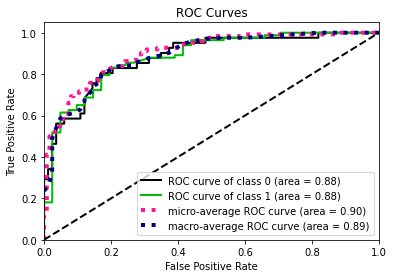

0.883925947693212


In [197]:
plot_roc(Y_test, svm_model.predict_proba(X_test_vec))
plt.show()
print(roc_auc_score(Y_test, y_test_pred_proba[:,1], average="macro"))

In [198]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [201]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear', 'poly'],
              'class_weight':['balanced', None],
}

In [208]:
grid = GridSearchCV(SVC(), param_grid, refit = True, scoring = "f1", cv=kfold, verbose=3)
grid.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.867 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.899 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.887 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.908 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.905 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.867 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.906 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.873 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.917 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=lin

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='f1', verbose=3)

In [209]:
print(grid.best_params_)

{'C': 10, 'class_weight': None, 'gamma': 1, 'kernel': 'poly'}


In [210]:
grid_predictions = grid.predict(X_test_vec)
print(classification_report(Y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.72      0.71      0.72        41
           1       0.86      0.87      0.86        83

    accuracy                           0.81       124
   macro avg       0.79      0.79      0.79       124
weighted avg       0.81      0.81      0.81       124



In [220]:
review = """To be fair i don't like this version, it's very loud and the sound quality is poor"""

review_tok = tokenize_list_of_text([review], custom_stopwords, False, 2)[1]
print(review_tok)
review_vec = review_vectors(review_tok[0], w2v_model.vector_size, [1 for x in range(len(review_tok[0]))])
pred = grid.predict(review_vec)
pred

total number of types extracted is: 7
[['fair', 'unlike', 'version', 'loud', 'sound', 'quality', 'poor']]
non trovo fair
non trovo version


array([0])